In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import json
from collections import Counter
import re

In [2]:
torch.cuda.empty_cache()

In [3]:

####################################################
# 1. Extend the model with a masking head (LM Head)
####################################################
class ESMCMasked(nn.Module):
    
    # A simple wrapper that takes a pre-trained ESM C model and adds
    # a masking (language modeling) head on top of the final hidden states.
    
    def __init__(self, base_model, hidden_dim=64, num_aa=33):
        super().__init__()
        self.base_model = base_model  # Pretrained ESM C model
        self.mask_head = nn.Linear(hidden_dim, num_aa)  # Simple linear LM head

    def forward(self, protein_obj, mask_positions=None):
        # Encode the protein to get initial embeddings
        encoded_seq = self.base_model.encode(protein_obj)
        # Obtain the hidden representations (logits call ensures forward pass)
        logits_out = self.base_model.logits(
            encoded_seq,
            LogitsConfig(sequence=True, return_embeddings=False)
        )
        # logits_out.logits.sequence is a list of length batch_size; here presumably 1
        # hidden has shape [L, hidden_dim] if single-sequence
        hidden = logits_out.logits.sequence[0]

        # Convert hidden from bfloat16 to float32 (match linear layer weights)
        hidden = hidden.to(self.mask_head.weight.dtype)

        # Pass through the custom LM head
        out_logits = self.mask_head(hidden)  # shape: [L, num_aa]

        if mask_positions is not None:
            # Return just the masked positions
            masked_logits = out_logits[mask_positions]
            return masked_logits, hidden
        else:
            # Or return logits for every position
            return out_logits

def load_finetuned_model(model_path, full_pretraining=False, device='cuda'):
    # Load checkpoint
    checkpoint = torch.load(model_path, map_location=device)
    config = checkpoint['config']
    
    # 1. Load base ESMC model
    base_model = ESMC.from_pretrained("esmc_300m").to(device)
    
    # 3. Wrap with ESMCMasked using saved config
    model = ESMCMasked(
        base_model,
        hidden_dim=config['hidden_dim'],
        num_aa=config['num_aa']
    ).to(device)
    
    # 4. Load trained weights
    model.load_state_dict(checkpoint['model_state_dict'])
    
    return model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [4]:

# -----------------------------------------------------------------------------
# Cell 2: Load the MAVE scores dataframe TP53 data/MAVEDB/urn_mavedb_00001211-0-2_scores.csv
mave_df = pd.read_csv('/global/scratch/users/sergiomar10/data/MAVEDB/urn_mavedb_00000054-a-1_scores.csv')

# -----------------------------------------------------------------------------
# Cell 3: Process mutation info and create a pivot table (score_matrix)
def extract_mutation_info(x):
    m = re.match(r"p\.([A-Za-z]{3})(\d+)([A-Za-z]{3})", x)
    if m:
        return m.group(1), float(m.group(2)), m.group(3)
    return None, None, None

# Extract mutation information into separate columns
mut_info = mave_df['hgvs_pro'].apply(lambda x: pd.Series(extract_mutation_info(x)))
mut_info.columns = ['WT', 'POS', 'MT']

# Append the mutation info to the original dataframe
mave_df = pd.concat([mave_df, mut_info], axis=1)

# Filter out any rows without a valid position and sort by position
mave_df = mave_df[mave_df['POS'].notna()].sort_values(by='POS')

# Create the pivot table: rows are positions and columns are mutant amino acids,
# filling each cell with the corresponding 'score' value.
score_matrix = mave_df.pivot_table(index='POS', columns='MT', values='score', aggfunc='first')

# Ensure the matrix includes exactly the 79 positions and 20 amino acids.
expected_positions = sorted(mave_df['POS'].unique())
expected_aas = ["Ala", "Arg", "Asn", "Asp", "Cys", "Glu", "Gln", "Gly",
                "His", "Ile", "Leu", "Lys", "Met", "Phe", "Pro", "Ser",
                "Thr", "Trp", "Tyr", "Val"]

score_matrix = score_matrix.reindex(expected_positions)
score_matrix = score_matrix.reindex(columns=expected_aas)


# -----------------------------------------------------------------------------
# Cell 4: Update the score_matrix index to use wild-type amino acids
score_matrix.index = mave_df[['WT','POS']].drop_duplicates(subset='POS').sort_values('POS')['WT'].values


# -----------------------------------------------------------------------------
# Cell 5: (Optional) Display the WT values per position
mave_df[['WT','POS']].drop_duplicates(subset='POS').sort_values('POS')['WT'].values


# -----------------------------------------------------------------------------
# Cell 6: Transpose the score_matrix
score_matrix = score_matrix.T


# -----------------------------------------------------------------------------
# Cell 7: Display score_matrix
score_matrix


,Met,Thr,Ala,Ile,Ile,Lys,Glu,Ile,Val,Ser,...,Glu,Asp,Gln,His,Thr,Gln,Ile,Thr,Lys,Val
MT,,,,,,,,,,,,,,,,,,,,,
Ala,NaN,2.275492,NaN,NaN,-1.291777,-1.356124,0.640134,0.153463,0.613465,-0.523153,...,0.254751,-0.717433,0.091048,0.187996,-1.292455,-0.208999,NaN,NaN,1.070763,-3.172111
Arg,NaN,0.551584,1.185872,NaN,NaN,1.063364,0.771999,-0.163769,-3.328586,-1.709003,...,-0.407212,0.142203,-0.182299,-0.703911,-0.114196,NaN,-1.538661,0.287496,0.367969,NaN
Asn,NaN,-3.204992,NaN,NaN,NaN,-1.045273,0.748427,-1.866036,-1.133374,-0.559444,...,-0.121080,-0.683842,-1.078989,-0.922673,0.837125,-1.479820,-0.057047,-3.383421,-1.264703,NaN
Asp,NaN,2.387178,0.769990,NaN,-3.464415,-2.726297,-0.123026,-1.990299,-1.414871,-2.848402,...,-0.604504,NaN,-0.853300,-0.358133,NaN,-2.572122,-1.735580,-2.953858,NaN,NaN
Cys,1.181219,-1.074245,NaN,NaN,-0.115974,-1.807664,-0.061898,NaN,0.247110,-1.500828,...,-2.399724,-1.899101,-1.530408,-0.023590,0.021597,-2.851204,NaN,-3.172111,NaN,NaN
Glu,NaN,NaN,NaN,NaN,NaN,-1.623520,NaN,-1.557606,-3.090800,-4.262091,...,NaN,-1.595705,0.322889,-0.006089,-0.293186,0.279743,NaN,NaN,-0.581657,0.193065
Gln,NaN,NaN,NaN,NaN,NaN,-0.718348,0.105656,-0.756951,-0.973935,-2.058591,...,-1.327746,-1.061723,NaN,-2.953858,-0.097215,NaN,NaN,NaN,0.228403,NaN
Gly,NaN,NaN,NaN,NaN,-2.787257,-0.985199,0.853580,-0.856274,-1.209570,-0.541544,...,NaN,-1.376907,0.153502,-0.055916,-0.221985,-2.903847,-3.358303,NaN,NaN,-2.736793
His,-2.675306,NaN,NaN,NaN,NaN,-0.201708,0.142965,0.254676,-0.804052,-1.103495,...,0.282124,0.138348,-1.419789,NaN,-2.409278,NaN,NaN,NaN,NaN,NaN


In [5]:
#TP53
wt_seq = 'MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLSPDDIEQWFTEDPGPDEAPRMPEAAPPVAPAPAAPTPAAPAPAPSWPLSSSVPSQKTYQGSYGFRLGFLHSGTAKSVTCTYSPALNKMFCQLAKTCPVQLWVDSTPPPGTRVRAMAIYKQSQHMTEVVRRCPHHERCSDSDGLAPPQHLIRVEGNLRVEYLDDRNTFRHSVVVPYEPPEVGSDCTTIHYNYMCNSSCMGGMNRRPILTIITLEDSSGNLLGRNSFEVRVCACPGRDRRTEEENLRKKGEPHHELPPGSTKRALPNNTSSSPQPKKKPLDGEYFTLQIRGRERFEMFRELNEALELKDAQAGKEPGGSRAHSSHLKSKKGQSTSRHKKLMFKTEGPDSD'

In [6]:
# -----------------------------------------------------------------------------
# Cell 8: (Commented out) Load the finetuned model and set it to evaluation mode
from esm.models.esmc import ESMC
from esm.sdk.api import ESMProtein, LogitsConfig

model = load_finetuned_model(
    "/global/scratch/users/sergiomar10/models/esm_c/masking/fine_tuned/False-Full_pretraining_20000_seq_2.pt",
    full_pretraining=False,  # Must match training setting!
    device=device
)
model.eval()  # Set to evaluation mode


# -----------------------------------------------------------------------------
# Cell 9: (Commented out) Define mappings for the 20 standard amino acids
amino_acids = "ARNDCEQGHILKMFPSTWYV"

aa_to_idx = {
    aa: model.base_model.tokenizer(text=aa).input_ids[1]  # index=1 to skip <cls> or start token
    for aa in amino_acids
}

idx_to_aa = {idx: aa for aa, idx in aa_to_idx.items()}

print(f"aa_to_idx: {aa_to_idx}", flush=True)
print(f"idx_to_aa: {idx_to_aa}", flush=True)


# -----------------------------------------------------------------------------
# Cell 11: Create the wild-type sequence, process it with the ESM model, and compute LLR
import numpy as np

three_to_one = {
    "Ala": "A", "Arg": "R", "Asn": "N", "Asp": "D", "Cys": "C",
    "Glu": "E", "Gln": "Q", "Gly": "G", "His": "H", "Ile": "I",
    "Leu": "L", "Lys": "K", "Met": "M", "Phe": "F", "Pro": "P",
    "Ser": "S", "Thr": "T", "Trp": "W", "Tyr": "Y", "Val": "V"
}

/clusterfs/nilah/sergio/miniconda3/envs/ESMC2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 4 files: 100%|██████████| 4/4 [00:00<00:00, 31126.56it/s]


aa_to_idx: {'A': 5, 'R': 10, 'N': 17, 'D': 13, 'C': 23, 'E': 9, 'Q': 16, 'G': 6, 'H': 21, 'I': 12, 'L': 4, 'K': 15, 'M': 20, 'F': 18, 'P': 14, 'S': 8, 'T': 11, 'W': 22, 'Y': 19, 'V': 7}
idx_to_aa: {5: 'A', 10: 'R', 17: 'N', 13: 'D', 23: 'C', 9: 'E', 16: 'Q', 6: 'G', 21: 'H', 12: 'I', 4: 'L', 15: 'K', 20: 'M', 18: 'F', 14: 'P', 8: 'S', 11: 'T', 22: 'W', 19: 'Y', 7: 'V'}


In [24]:

# Create the wild-type sequence string in one-letter codes.
wt_seq_str = "".join(mave_df[['WT','POS']].drop_duplicates(subset='POS').sort_values('POS')['WT'].map(three_to_one))

wt_seq_str = "MSLVDLGKKLLEAARAGQDDEVRILMANGAPFTTDWLGTSPLHLAAQYGHYSTTEVLLRAGVSRDARTKVDRTPLHMAASEGHASIVEVLLKHGADVNAKDMLKMTALHWATEHNHQEVVELLIKYGADVHTQSKFCKTAFDISIDNGNEDLAEILQIAMQNQINTNPESPDTVTIHAATPQFIIGPGGVVNLTGLVSSENSSKATDETGVSAVQFGNSSTSVLATLAALAEASAPLSNSSETPVVATEEVVTAESVDGAIQQVVSSGGQQVITIVTDGIQLGNLHSIPTSGIGQPIIVTMPDGQQVLTVPATDIAEETVISEEPPAKRQCIEIIENRVESAEIEEREALQKQLDEANREAQKYRQQLLKKEQEAEAYRQKLEAMTRLQTNKEAV"

# Process the wild-type sequence with the ESM model.
original_protein = ESMProtein(sequence=wt_seq_str)
original_tensor = model.base_model.encode(original_protein)
orig_token_ids = original_tensor.sequence

In [25]:

# Collect valid positions (ignoring start/end tokens)
orig_valid_positions = []
for pos in range(1, len(orig_token_ids) - 1):
    token_id = int(orig_token_ids[pos].item())
    token_str = model.base_model.tokenizer.decode([token_id]).strip()
    if token_str in aa_to_idx:
        orig_valid_positions.append(pos)
orig_valid_positions_tensor = torch.tensor(orig_valid_positions, device=device)

with torch.no_grad():
    orig_logits, _ = model(original_protein, mask_positions=orig_valid_positions_tensor)
# orig_logits has shape [L, 20] where L should equal len(wt_seq_str)
orig_ll = orig_logits  # Log likelihoods

In [26]:

# Define the standard 20 amino acids (ordered according to aa_to_idx)
std_aas = sorted(aa_to_idx.keys(), key=lambda x: aa_to_idx[x])
# Reorder the logits to follow the sorted order (columns correspond to std_aas)
orig_ll_matrix = orig_ll[:, [aa_to_idx[aa] for aa in std_aas]].cpu().numpy()

# Compute the LLR matrix by subtracting, at each position, the log likelihood of the WT amino acid.
LLR_matrix = np.zeros_like(orig_ll_matrix)
for i in range(orig_ll_matrix.shape[0]):
    wt_aa = wt_seq_str[i]
    wt_idx = std_aas.index(wt_aa)
    LLR_matrix[i, :] = orig_ll_matrix[i, :] - orig_ll_matrix[i, wt_idx]

# Create a DataFrame for better readability.
LLR_df = pd.DataFrame(
    LLR_matrix, 
    index=[f"{i+1}_{wt}" for i, wt in enumerate(wt_seq_str)], 
    columns=std_aas
)



In [27]:
LLR_df = LLR_df.T

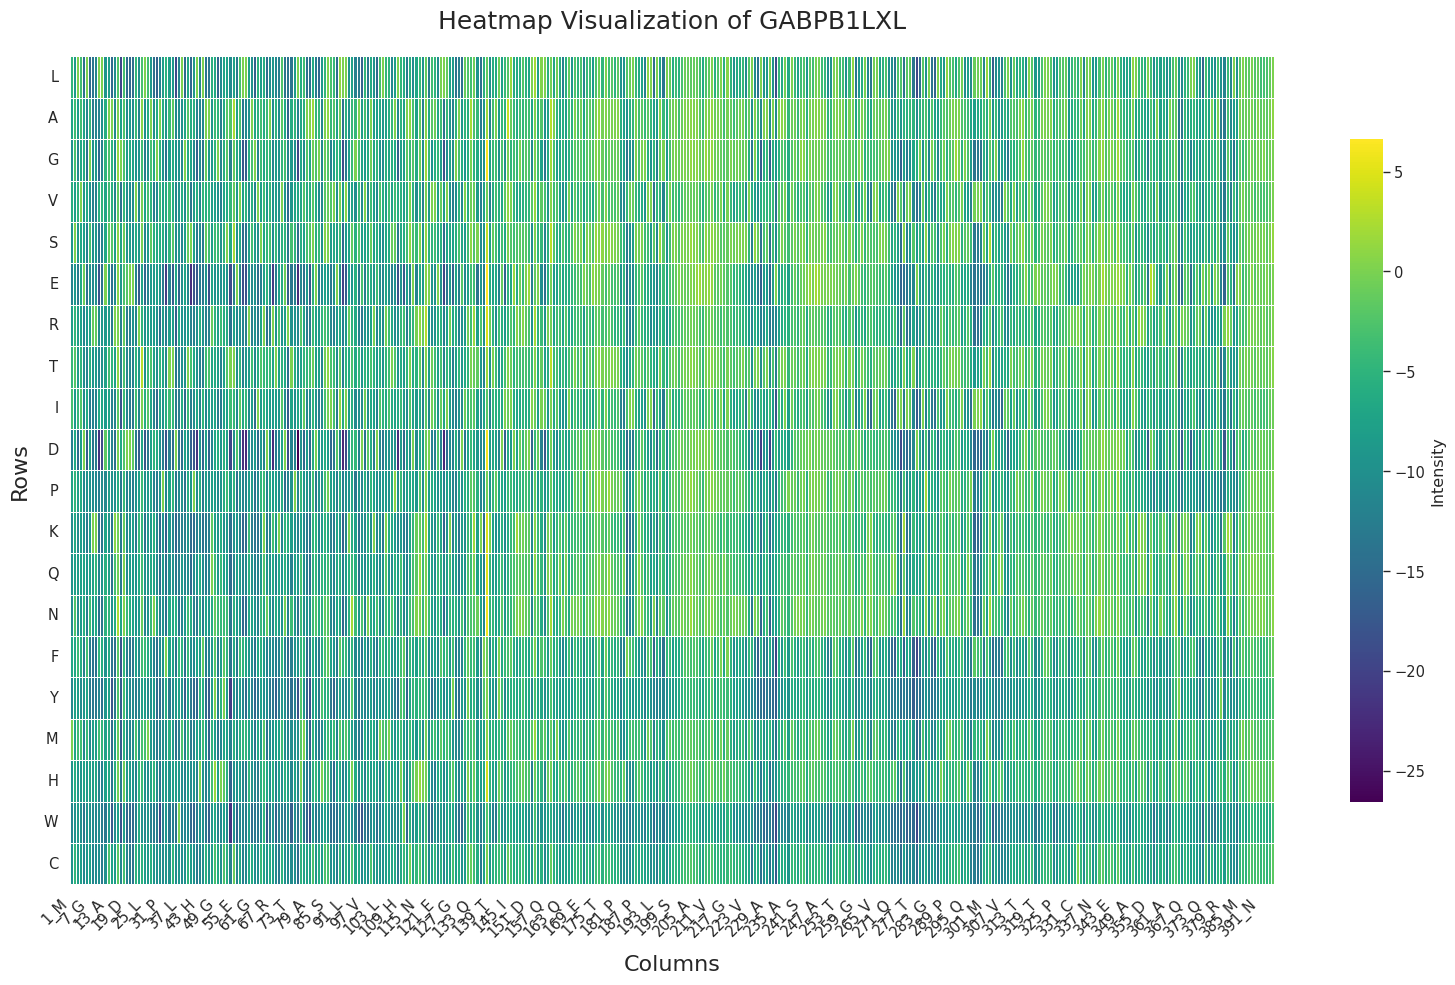

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set an overall theme for the plot
sns.set_theme(context="paper", style="white", font_scale=1.2)

# Set up the figure size; adjust as needed for your data dimensions
plt.figure(figsize=(16, 10))

# Create the heatmap. Customize the colormap, line widths, and color bar properties.
ax = sns.heatmap(LLR_df, 
                 cmap="viridis",      # You can choose another palette if desired (e.g., "coolwarm")
                 linewidths=0.5, 
                 linecolor="white", 
                 cbar_kws={"shrink": 0.8, "label": "Intensity"},
                 square=False)

# Add titles and labels with appropriate font sizes
plt.title("Heatmap Visualization of GABPB1LXL", fontsize=18, pad=20)
plt.xlabel("Columns", fontsize=16, labelpad=10)
plt.ylabel("Rows", fontsize=16, labelpad=10)

# Improve the layout and adjust tick parameters for clarity
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()

# Display the heatmap
plt.show()

In [31]:
LLR_df.to_csv('ESMC_GABPB1LXL_mt.csv')

In [30]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
score_matrix

,Met,Thr,Ala,Ile,Ile,Lys,Glu,Ile,Val,Ser,...,Glu,Asp,Gln,His,Thr,Gln,Ile,Thr,Lys,Val
MT,,,,,,,,,,,,,,,,,,,,,
Ala,NaN,2.275492,NaN,NaN,-1.291777,-1.356124,0.640134,0.153463,0.613465,-0.523153,...,0.254751,-0.717433,0.091048,0.187996,-1.292455,-0.208999,NaN,NaN,1.070763,-3.172111
Arg,NaN,0.551584,1.185872,NaN,NaN,1.063364,0.771999,-0.163769,-3.328586,-1.709003,...,-0.407212,0.142203,-0.182299,-0.703911,-0.114196,NaN,-1.538661,0.287496,0.367969,NaN
Asn,NaN,-3.204992,NaN,NaN,NaN,-1.045273,0.748427,-1.866036,-1.133374,-0.559444,...,-0.121080,-0.683842,-1.078989,-0.922673,0.837125,-1.479820,-0.057047,-3.383421,-1.264703,NaN
Asp,NaN,2.387178,0.769990,NaN,-3.464415,-2.726297,-0.123026,-1.990299,-1.414871,-2.848402,...,-0.604504,NaN,-0.853300,-0.358133,NaN,-2.572122,-1.735580,-2.953858,NaN,NaN
Cys,1.181219,-1.074245,NaN,NaN,-0.115974,-1.807664,-0.061898,NaN,0.247110,-1.500828,...,-2.399724,-1.899101,-1.530408,-0.023590,0.021597,-2.851204,NaN,-3.172111,NaN,NaN
Glu,NaN,NaN,NaN,NaN,NaN,-1.623520,NaN,-1.557606,-3.090800,-4.262091,...,NaN,-1.595705,0.322889,-0.006089,-0.293186,0.279743,NaN,NaN,-0.581657,0.193065
Gln,NaN,NaN,NaN,NaN,NaN,-0.718348,0.105656,-0.756951,-0.973935,-2.058591,...,-1.327746,-1.061723,NaN,-2.953858,-0.097215,NaN,NaN,NaN,0.228403,NaN
Gly,NaN,NaN,NaN,NaN,-2.787257,-0.985199,0.853580,-0.856274,-1.209570,-0.541544,...,NaN,-1.376907,0.153502,-0.055916,-0.221985,-2.903847,-3.358303,NaN,NaN,-2.736793
His,-2.675306,NaN,NaN,NaN,NaN,-0.201708,0.142965,0.254676,-0.804052,-1.103495,...,0.282124,0.138348,-1.419789,NaN,-2.409278,NaN,NaN,NaN,NaN,NaN


In [ ]:
LLR_df

,1_M,2_T,3_A,4_I,5_I,6_K,7_E,8_I,9_V,10_S,...,394_E,395_D,396_Q,397_H,398_T,399_Q,400_I,401_T,402_K,403_V
L,-5.764744,-2.656442,-2.079458,0.720016,1.397283,-7.716395,-5.579037,0.518982,-4.766330,-10.004466,...,-1.357067,-1.471688,0.402452,0.688029,1.138422,0.058105,0.495127,-0.651314,-0.294043,1.527959
A,-8.029126,-0.138649,0.000000,-0.771157,-0.931587,-8.309351,-3.551212,-2.651493,-4.686029,-3.732482,...,-1.419602,-1.370382,0.898467,0.810653,0.491764,0.606141,-1.008568,-0.423256,0.148829,-1.304762
G,-8.417661,-2.638985,0.061102,-2.423902,-4.320272,-6.657541,-0.975316,-7.485518,-10.711058,-2.945222,...,-0.941572,-0.936336,0.789541,0.350632,-0.378279,0.339553,-2.746914,-0.432509,-0.381010,-3.055999
V,-7.578928,-2.767557,-2.595712,-0.488568,-0.027504,-8.647110,-5.432069,-1.545899,0.000000,-8.977525,...,-2.032638,-2.214898,-0.192661,-0.285059,-0.341734,-0.803259,-0.408121,-1.057194,-0.730398,0.000000
S,-8.971721,0.109509,1.217686,-0.375093,-2.760624,-6.451764,-0.313272,-4.129252,-7.649035,0.000000,...,-0.612824,-0.613750,1.398368,1.192991,0.382790,0.927422,-1.386403,0.379529,0.820185,-1.461826
E,-10.772833,-7.407496,-3.262736,-7.155905,-8.031852,-7.965774,0.000000,-12.648810,-13.491043,-9.257469,...,0.000000,0.204356,0.584502,0.461463,-1.474524,-0.014058,-2.244983,0.317110,0.413462,-2.618629
R,-6.158482,-2.780237,-0.256372,1.035149,-3.035990,0.514907,-0.548097,-2.040062,-9.836866,-5.689760,...,-1.018539,-0.946538,0.733002,0.630059,0.123910,0.447816,-1.538951,0.355597,0.586631,-1.757403
T,-6.318405,0.000000,-0.217390,-0.830014,-2.104643,-6.521978,-2.734321,-2.307858,-6.176580,-3.891795,...,-2.061561,-1.696027,0.302332,0.728369,0.000000,0.064005,-1.244104,0.000000,-0.330341,-1.460596
I,-5.260795,-2.885692,-2.403580,0.000000,0.000000,-8.989459,-6.329237,0.000000,-1.930957,-10.584627,...,-2.190487,-2.248759,0.046791,0.092365,0.406327,-0.450867,0.000000,-1.249803,-0.755897,0.167192
D,-11.471800,-6.547557,-2.069468,-6.923724,-9.856842,-10.153618,0.393745,-14.154816,-14.375018,-7.175875,...,-0.133903,0.000000,0.813877,0.361831,-1.414768,-0.180174,-2.893921,-0.154089,0.229017,-3.292117


In [ ]:
# -----------------------------------------------------------------------------
# Cell 13: Rename index and columns of score_matrix using three_to_one mapping
score_matrix.rename(index=three_to_one, columns=three_to_one, inplace=True)


# -----------------------------------------------------------------------------
# Cell 14: Reset index of score_matrix
score_matrix.reset_index(inplace=True)


# -----------------------------------------------------------------------------
# Cell 15: Reset index of LLR_df
LLR_df.reset_index(inplace=True)


# -----------------------------------------------------------------------------
# Cell 16: Sort LLR_df by the 'index' column and reset the index
LLR_df = LLR_df.sort_values(by='index').reset_index(drop=True)


# -----------------------------------------------------------------------------
# Cell 17: Sort score_matrix by the 'MT' column
score_matrix = score_matrix.sort_values(by='MT')  # .iloc[10]['MT']


# -----------------------------------------------------------------------------
# Cell 18: Flatten matrices and create a DataFrame of scores
score_matrix_array = score_matrix.iloc[:, 1:].values.flatten()
LLR_df_array = LLR_df.iloc[:, 1:].values.flatten()

dms_scores = pd.DataFrame({'score_matrix': score_matrix_array, 'LLR_df': LLR_df_array})
dms_scores = dms_scores[dms_scores['score_matrix'].notna()]


# -----------------------------------------------------------------------------
# # Cell 19: Save the LLR and score matrices to CSV files
# LLR_df.to_csv('/global/scratch/users/sergiomar10/data/MAVEDB/LLR_df_array_GABPA.csv')
# score_matrix.to_csv('/global/scratch/users/sergiomar10/data/MAVEDB/score_matrix_GABPA.csv')


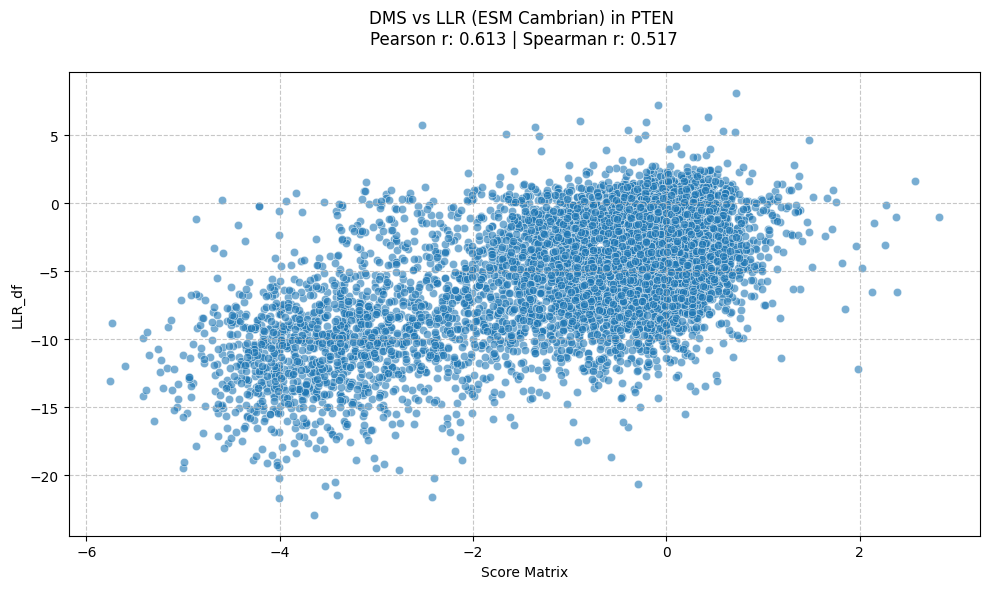

In [ ]:
score_matrix_array = score_matrix.iloc[:, 1:].values.flatten()
LLR_df_array = LLR_df.iloc[:, 1:].values.flatten()

dms_scores = pd.DataFrame({'score_matrix': score_matrix_array, 'LLR_df': LLR_df_array})
dms_scores = dms_scores[dms_scores['score_matrix'].notna()]

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import numpy as np

# Remove NaN values for correlation calculation
dms_scores_clean = dms_scores.dropna()

# Calculate correlations
pearson_corr, _ = pearsonr(dms_scores_clean['score_matrix'], dms_scores_clean['LLR_df'])
spearman_corr, _ = spearmanr(dms_scores_clean['score_matrix'], dms_scores_clean['LLR_df'])

# Create the scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=dms_scores, x='score_matrix', y='LLR_df', alpha=0.6)

# Customize the plot
plt.title(f'DMS vs LLR (ESM Cambrian) in PTEN \n'
          f'Pearson r: {pearson_corr:.3f} | Spearman r: {spearman_corr:.3f}',
          pad=20)
plt.xlabel('Score Matrix')
plt.ylabel('LLR_df')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


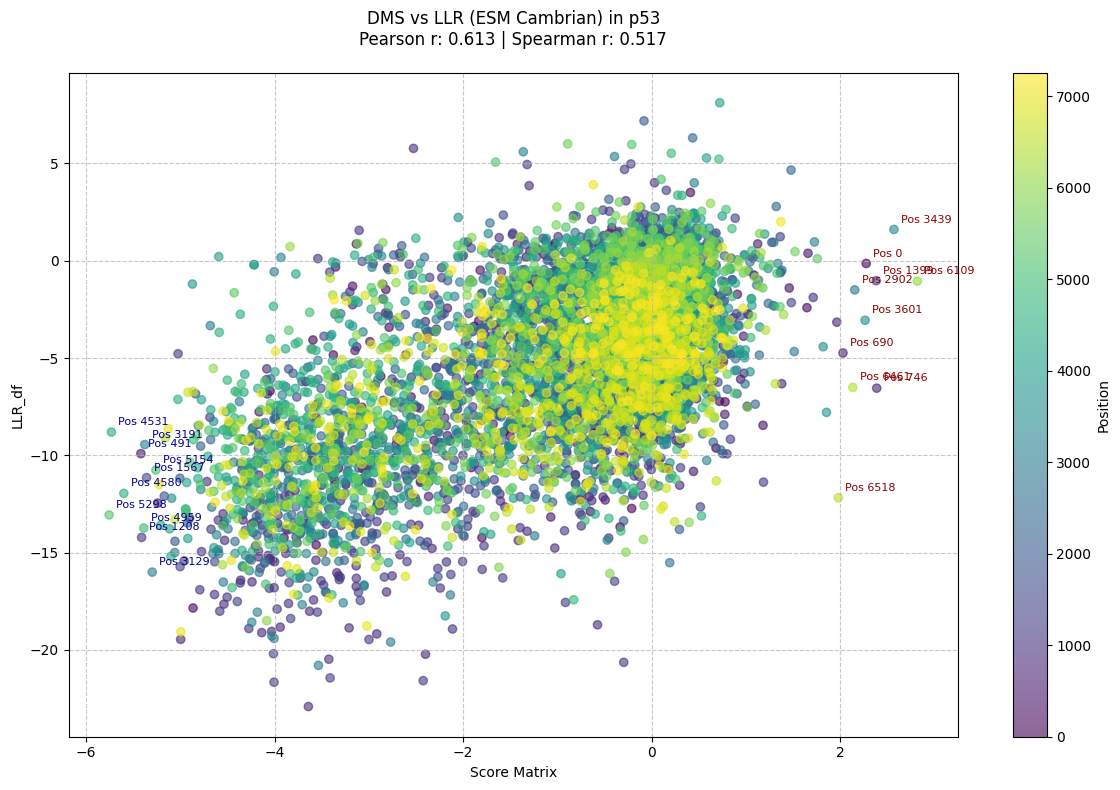

In [ ]:
# Assuming score_matrix and LLR_df are already defined
score_matrix_array = score_matrix.iloc[:, 1:].values.flatten()
LLR_df_array = LLR_df.iloc[:, 1:].values.flatten()  # Assuming LLR_df exists

dms_scores = pd.DataFrame({'score_matrix': score_matrix_array, 'LLR_df': LLR_df_array})
dms_scores = dms_scores[dms_scores['score_matrix'].notna()]

# Remove NaN values for correlation calculation
dms_scores_clean = dms_scores.dropna()

# Calculate correlations
pearson_corr, _ = pearsonr(dms_scores_clean['score_matrix'], dms_scores_clean['LLR_df'])
spearman_corr, _ = spearmanr(dms_scores_clean['score_matrix'], dms_scores_clean['LLR_df'])

# Add position information
dms_scores_clean['position'] = range(len(dms_scores_clean))

# Create the scatterplot with color by position
plt.figure(figsize=(12, 8))
scatter = plt.scatter(data=dms_scores_clean, 
                      x='score_matrix', 
                      y='LLR_df', 
                      c='position',  # Color by position
                      cmap='viridis',  # Color map
                      alpha=0.6)

# Add colorbar
plt.colorbar(scatter, label='Position')

# Identify top and bottom 10 points based on score_matrix
top_10 = dms_scores_clean.nlargest(10, 'score_matrix')
bottom_10 = dms_scores_clean.nsmallest(10, 'score_matrix')

# Annotate top 10 points
for idx, row in top_10.iterrows():
    plt.annotate(f'Pos {int(row["position"])}', 
                 (row['score_matrix'], row['LLR_df']),
                 xytext=(5, 5),
                 textcoords='offset points',
                 fontsize=8,
                 color='darkred')

# Annotate bottom 10 points
for idx, row in bottom_10.iterrows():
    plt.annotate(f'Pos {int(row["position"])}', 
                 (row['score_matrix'], row['LLR_df']),
                 xytext=(5, 5),
                 textcoords='offset points',
                 fontsize=8,
                 color='darkblue')

# Customize the plot
plt.title(f'DMS vs LLR (ESM Cambrian) in p53\n'
          f'Pearson r: {pearson_corr:.3f} | Spearman r: {spearman_corr:.3f}',
          pad=20)
plt.xlabel('Score Matrix')
plt.ylabel('LLR_df')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [ ]:
print('Done')
break

Done


In [ ]:
# -----------------------------------------------------------------------------
# Final cell: Reload the CSV files and adjust the dataframes
LLR_df = pd.read_csv('/global/scratch/users/sergiomar10/data/MAVEDB/LLR_df_array_GABPA.csv')
score_matrix = pd.read_csv('/global/scratch/users/sergiomar10/data/MAVEDB/score_matrix_GABPA.csv')
LLR_df = LLR_df.iloc[:, 1:]
score_matrix = score_matrix.iloc[:, 1:]


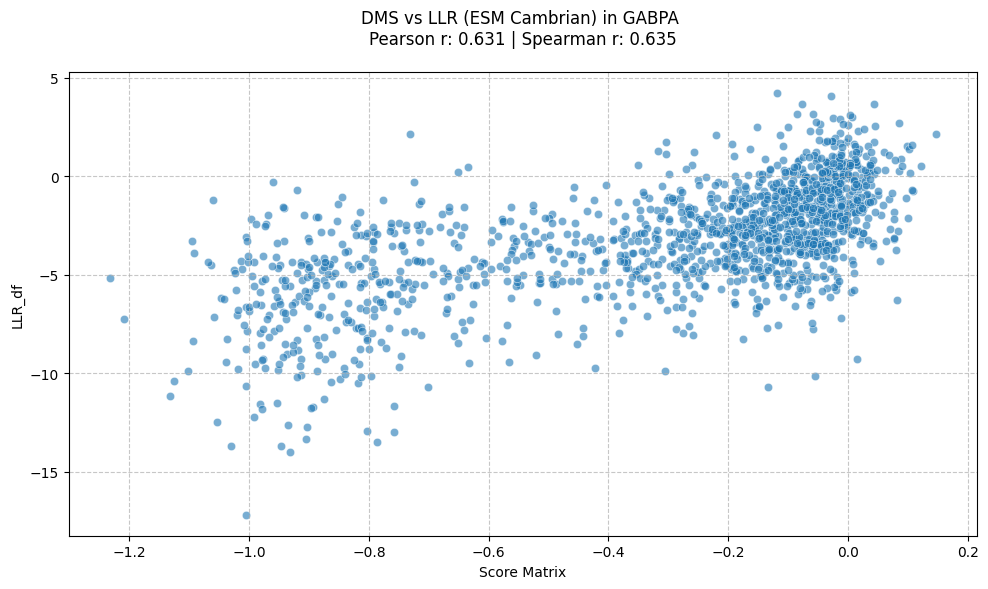

In [ ]:
score_matrix_array = score_matrix.iloc[:, 1:].values.flatten()
LLR_df_array = LLR_df.iloc[:, 1:].values.flatten()

dms_scores = pd.DataFrame({'score_matrix': score_matrix_array, 'LLR_df': LLR_df_array})
dms_scores = dms_scores[dms_scores['score_matrix'].notna()]

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import numpy as np

# Remove NaN values for correlation calculation
dms_scores_clean = dms_scores.dropna()

# Calculate correlations
pearson_corr, _ = pearsonr(dms_scores_clean['score_matrix'], dms_scores_clean['LLR_df'])
spearman_corr, _ = spearmanr(dms_scores_clean['score_matrix'], dms_scores_clean['LLR_df'])

# Create the scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=dms_scores, x='score_matrix', y='LLR_df', alpha=0.6)

# Customize the plot
plt.title(f'DMS vs LLR (ESM Cambrian) in GABPA \n'
          f'Pearson r: {pearson_corr:.3f} | Spearman r: {spearman_corr:.3f}',
          pad=20)
plt.xlabel('Score Matrix')
plt.ylabel('LLR_df')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


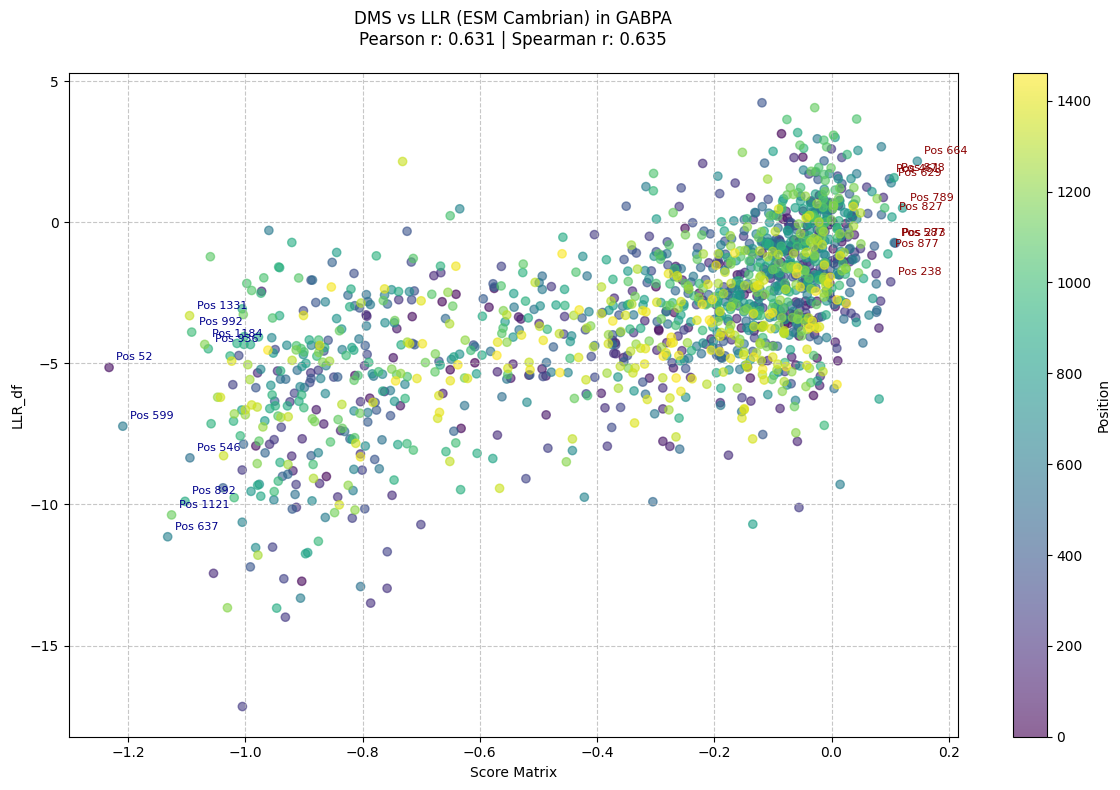

In [ ]:
# Assuming score_matrix and LLR_df are already defined
score_matrix_array = score_matrix.iloc[:, 1:].values.flatten()
LLR_df_array = LLR_df.iloc[:, 1:].values.flatten()  # Assuming LLR_df exists

dms_scores = pd.DataFrame({'score_matrix': score_matrix_array, 'LLR_df': LLR_df_array})
dms_scores = dms_scores[dms_scores['score_matrix'].notna()]

# Remove NaN values for correlation calculation
dms_scores_clean = dms_scores.dropna()

# Calculate correlations
pearson_corr, _ = pearsonr(dms_scores_clean['score_matrix'], dms_scores_clean['LLR_df'])
spearman_corr, _ = spearmanr(dms_scores_clean['score_matrix'], dms_scores_clean['LLR_df'])

# Add position information
dms_scores_clean['position'] = range(len(dms_scores_clean))

# Create the scatterplot with color by position
plt.figure(figsize=(12, 8))
scatter = plt.scatter(data=dms_scores_clean, 
                      x='score_matrix', 
                      y='LLR_df', 
                      c='position',  # Color by position
                      cmap='viridis',  # Color map
                      alpha=0.6)

# Add colorbar
plt.colorbar(scatter, label='Position')

# Identify top and bottom 10 points based on score_matrix
top_10 = dms_scores_clean.nlargest(10, 'score_matrix')
bottom_10 = dms_scores_clean.nsmallest(10, 'score_matrix')

# Annotate top 10 points
for idx, row in top_10.iterrows():
    plt.annotate(f'Pos {int(row["position"])}', 
                 (row['score_matrix'], row['LLR_df']),
                 xytext=(5, 5),
                 textcoords='offset points',
                 fontsize=8,
                 color='darkred')

# Annotate bottom 10 points
for idx, row in bottom_10.iterrows():
    plt.annotate(f'Pos {int(row["position"])}', 
                 (row['score_matrix'], row['LLR_df']),
                 xytext=(5, 5),
                 textcoords='offset points',
                 fontsize=8,
                 color='darkblue')

# Customize the plot
plt.title(f'DMS vs LLR (ESM Cambrian) in GABPA\n'
          f'Pearson r: {pearson_corr:.3f} | Spearman r: {spearman_corr:.3f}',
          pad=20)
plt.xlabel('Score Matrix')
plt.ylabel('LLR_df')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
